# Data Cleaning

In [0]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter

import html
import re
from scipy import stats
import random
random.seed()

!pip install nltk
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
generic_tweets = pd.read_csv('generic_tweets.txt')
election_tweets = pd.read_csv('Canadian_elections_2019.csv')

In [0]:
print(generic_tweets.shape,election_tweets.shape)
print(generic_tweets.columns,election_tweets.columns)

(200000, 6) (2133, 3)
Index(['class', 'id', 'date', 'query', 'user', 'text'], dtype='object') Index(['sentiment', 'negative_reason', 'text'], dtype='object')


In [0]:
generic_tweets.head(3)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [0]:
election_tweets.head(3)

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."


In [0]:
with open('stop_words.txt','r') as f:
  stop_words = f.read().split('\n')

Data Cleaning Strategy:
1.remove html tags,URLs:Use regulart expression to match the html tags and remove them.
2.replace Html character codes with ASCII:Use regulart expression to match the codes and replace them with ascii code.
3.Lower case:Series str has api lower to convert characters to lowercase
4.remove stop words:First, use nltk to tokenize the string then remove all words in the stopword list.

In [0]:
class DataCleaner(object):
  def __init__(self,stop_Word):
    
    self.stopWord=stop_Word
  def clean(self,data):
    regex_pat = re.compile(r"\s*<.*?>", flags=re.IGNORECASE)#remove tages
    data=data.str.replace(regex_pat,'')
    #use replace compile to put regular expression on series, pandas series has many string apis
    data=html.unescape(data)#html encoding

    regex_link = re.compile(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+', flags=re.IGNORECASE)
    data=data.str.replace(regex_link,'')#remove links
    data=data.str.lower()#to lowercase
    regex_NoneChar = re.compile(r"[^\s\w]+", flags=re.IGNORECASE)
    data=data.str.replace(regex_NoneChar,'')

    tokenizer = RegexpTokenizer(r'\w+')
    data=data.apply(lambda data: nltk.word_tokenize(data))
    data=data.apply(lambda x: [item for item in x if item not in self.stopWord])
    
    data=data.apply(lambda x:' '.join(x))
    return data
    


In [0]:
c1=DataCleaner(stop_words)
result=c1.clean(generic_tweets['text'])

In [0]:
result.head()

0    switchfoot awww bummer shoulda david carr thir...
1    upset cant update facebook texting cry result ...
2    kenichan dived times ball managed save 50 rest...
3                                body feels itchy fire
4                    nationwideclass behaving mad cant
Name: text, dtype: object

In [0]:
generic_tweets['cleaned_text']=result
generic_tweets.head()

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting cry result ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived times ball managed save 50 rest...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad cant


# Exploratory analysis

Hash Tag Strategy:
1.Find the single word after @ and # symbol:these two symbols are always followed with topic name or party leader account, which can be used to identify the party that the tweet belongs to.
2.Select the words that each party is represented and combine them into three lists.
3.Tokenize the tweets into list of tokens and match the tokens with the party key word list to identify the party.
4.Count the number of each party's apperence in the same tweet and mark the tweet with the party name that occured the most, and if no party token appeared in the tweet, just mark it as none.

In [0]:
def hashTag(election_TW):
  conservative=['conservatives','andrewscheer','cpc','cpc_hq','conservative','lyingandy',"harper", "steven"]
  liberal=['lpc','justintrudeau','liberal_party','liberal','teamtrudeau','trudeau', 'justin','trudeaumustgo']
  ndp=['emilietaman','thejagmeetsingh','ndp','uprisingh',"orange","quebec","tommulcair","mulcair","ptndp","ready4change"]
  hashTag_list=[]
  index=0
  for word in election_TW:
    tag=' '.join(re.findall(r'(?<=#)[^\s]+\s?',word))#find word after #
    tagLabel=tag.split()
    at=' '.join(re.findall(r'(?<=@)[^\s]+\s?',word))#find word after @
    atLabel=tag.split()
    tagList=tagLabel+atLabel#join two list together

    count_liberal=0
    count_conservative=0
    count_ndp=0
    for item in tagList:#count the number of each party afteer symbol
      if item in conservative:
        count_conservative+=1
      if item in liberal:
        count_liberal+=1
      if item in ndp:
        count_ndp+=1
    
    tokenizer=RegexpTokenizer(r'\w+')#tokenize the tweet and search for same tokens
    word_list=tokenizer.tokenize(word)
    if (set(word_list) & set(liberal)):
      for i in word_list:
        if i in liberal:
          count_liberal+=1

    if (set(word_list) & set(conservative)):
      for i in word_list:
        if i in conservative:
          count_conservative+=1
      
    if (set(word_list) & set(ndp)):
      for i in word_list:
        if i in ndp:
          count_ndp+=1
          
    if count_liberal==0 and count_conservative==0 and count_ndp==0: 
      hashTag_list.append('none')
      continue
    most_Count=max(count_liberal,count_conservative,count_ndp)
    if count_liberal==most_Count:
      hashTag_list.append('liberal')
      continue
    if count_conservative==most_Count:
      hashTag_list.append('conservative')
      continue
    if count_ndp==most_Count:
      hashTag_list.append('ndp')
      continue
  return hashTag_list
      

In [0]:
election_tweets['text']=election_tweets['text'].str.lower()
election_TW=election_tweets['text'].values

In [0]:
partyLabel=hashTag(election_TW)
election_tweets['party']=partyLabel

In [0]:
election_tweets.head(20)

,sentiment,negative_reason,text,party
0,negative,Women Reproductive right and Racism,"b""@rosiebarton so instead of your suggestion, ...",conservative
1,positive,NaN,"b""#allwomanspacewalk it's real!\n@space_statio...",none
2,negative,Economy,"b""#brantford it's going to cost you $94 billio...",liberal
3,positive,NaN,"b""#canada #canadaelection2019 #canadavotes \n#...",none
4,negative,Economy,"b""#canada #taxpayers are sick &amp; tired of h...",liberal
5,negative,Others,"b""#canadavotes2019 #elxn43 #cdnpoli - facts - ...",conservative
6,positive,NaN,"b""#cdnmedia #elxn43 #cdnpoli #ppc rocky dong h...",none
7,positive,NaN,"b""#cdnpoli #elxn43 the liberals ++ more than d...",ndp
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\ncanada, don...",none
9,negative,Scandal,"b""#cpckinsellagate\nlet's see the receipts. wh...",none


In [0]:
k=' '.join(re.findall(r'(?<=#)[^\s]+\s?','#@data #daim dafad'))
print(k.split())

['@data', 'daim']


In [0]:
election_tweets['party'].value_counts()

none            1142
liberal          419
conservative     409
ndp              163
Name: party, dtype: int64

# Graph & Plots

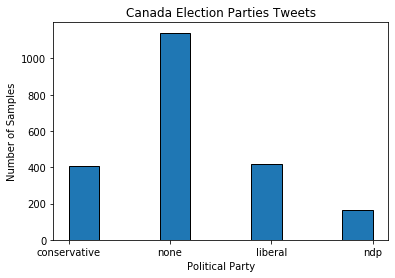

In [0]:
plt.hist(election_tweets['party'], bins=10, edgecolor='black')
plt.title("Canada Election Parties Tweets")
plt.xlabel("Political Party")
plt.ylabel("Number of Samples")
plt.show()

The above graph shows the relation between the name of each political party and their related tweet number. From the graph we can see that the majority of the tweets does not have information related to any party, in addition to that the liberal and conservative are basically the same in number and both of them are more hot discussed than ndp.

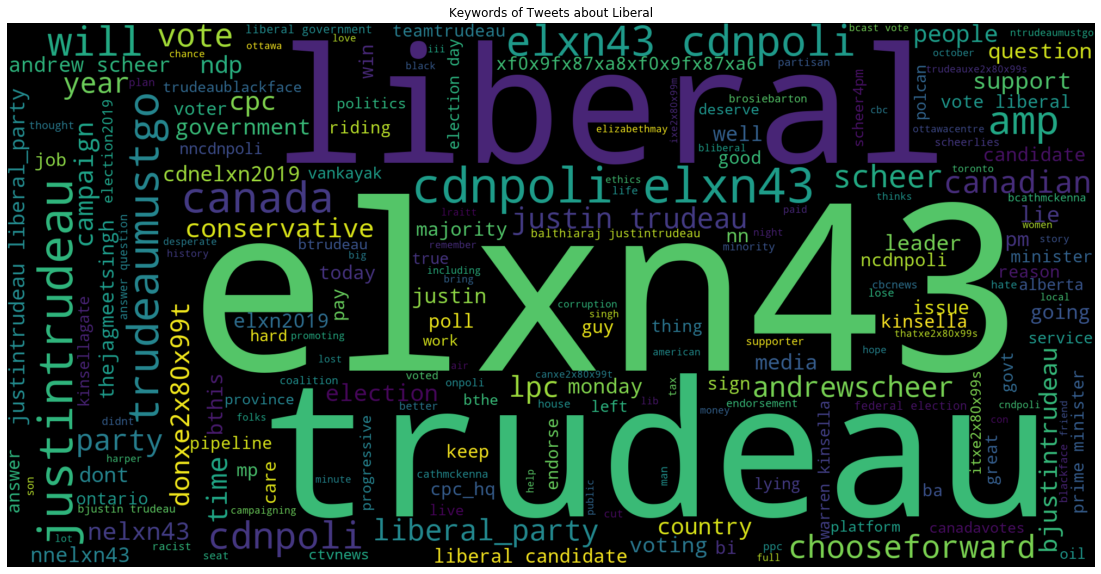

In [0]:
liberal_Tweets=election_tweets.loc[election_tweets['party']=='liberal','text']
c2=DataCleaner(stop_words)
result_liberal_Tweets=c2.clean(liberal_Tweets)
liberal_Tweets=result_liberal_Tweets.values
liberal_Tweets=' '.join(liberal_Tweets)
wordcloud = WordCloud(width = 2000, height = 1000).generate(liberal_Tweets)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about Liberal')
plt.axis("off")
plt.show()

The top ranked words about liberal party.

#Model Preparation

To encode the tweets into numerical values, I used two methods, tf_idf and bag of words(term frequency).
To implement tfidf, I used sklearn TfidfVectorizer which first vectorize the tweets using CounterVectorize then calculate the tf_idf score, to limit the dimension of feature space I limit the maximum number of features to 2000 then sum the tfidf score of words after that rank the words and select the top 500 word as features. 
For bag of words model, I simply count the number of each word and select the top 500 most common words as features, then jusge if a word appears in the tweet to vectorize the feature.

In [0]:
cleanTweets=generic_tweets['cleaned_text']

In [0]:
def getTfidfFeatures(cleanTweets):
  #vectorize feature and sum 
  tfidfV = TfidfVectorizer(max_features=2000)
  train_tfidf = tfidfV.fit_transform(cleanTweets)
  tfIdfSum=train_tfidf.sum(axis=0)
  featureNames=tfidfV.get_feature_names()
  #build feature dataframe
  featureDF=pd.DataFrame(tfIdfSum, columns=featureNames)
  train_tfidf=train_tfidf.toarray()
  rawDF=pd.DataFrame(train_tfidf, columns=featureNames)
  #rank feature by tf idf score
  featureDF=featureDF.sort_values(by=0,axis=1,ascending=True)#not '0'!!!just 0
  extractedFeatures=featureDF[featureDF.columns[-500:]]
  realFeatureNames=extractedFeatures.columns
  rawDF=rawDF.loc[:,realFeatureNames]
  return rawDF

In [0]:
tfidf_FeatureDF=getTfidfFeatures(cleanTweets)

In [0]:
tfidf_FeatureDF.head()

,spend,prom,absolutely,plan,spent,100,fb,longer,easter,fell,shame,lil,mum,learn,myspace,xxx,horrible,story,worse,pictures,warm,jonas,tickets,sat,youve,store,chance,point,upset,lazy,fair,hanging,hows,bet,three,exams,nap,worst,ice,ppl,...,gon,week,hey,hate,ive,yeah,better,tonight,watching,school,bad,bed,happy,didnt,nice,haha,sad,feel,fun,ill,amp,tomorrow,sleep,hope,great,twitter,morning,well,night,will,lol,time,cant,today,love,going,dont,work,day,good
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.246362,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194180,0.191824,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507962,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [0]:
genericLabels=generic_tweets['class']
genericLabels=genericLabels.replace(4,1)

In [0]:
genericLabels.unique()

array([0, 1])

In [0]:
def getBogData(twArray,k):
  counter=Counter()
  np_array= []
  for item in twArray:
    counter.update([word for word in re.findall(r'\w+', item)]) #if word not in noise_word
    
    # select most frequent k features            
  topk = counter.most_common(k) 
  nameList=[]
  for item in topk:
    nameList.append(item[0])
  print('finish')
  for item in twArray:
    tempCounter = Counter([word for word in re.findall(r'\w+', item)] )
            # if the word appears in the doc, then count the frequency, else 0
    topkintweet = [tempCounter[word] if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
            # create a list for top k words with encoded target and its label
    np_array.append(topkintweet)
  feature_df = pd.DataFrame(np_array,columns=nameList)
  return feature_df

In [0]:
twArray=generic_tweets['cleaned_text'].values
bogDF=getBogData(twArray,500)

finish


In [0]:
bogDF.head()

,good,day,work,going,dont,today,cant,love,time,will,lol,night,well,morning,amp,twitter,2,great,tomorrow,hope,sleep,ill,feel,fun,didnt,haha,sad,nice,happy,bad,bed,ive,school,better,tonight,watching,week,gon,people,wait,...,yep,asot400,broken,message,easy,30,tickets,lil,jonas,figure,wolverine,chance,xxx,sat,lonely,nap,youve,1st,website,worst,team,lazy,tweeting,word,worse,smile,photo,inside,understand,episode,myspace,exams,story,bank,huge,david,hows,upset,fb,warm
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Model Implementation & Results

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from  sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [0]:
import scipy.stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    mu,sd = np.mean(a),np.std(a)
    z = scipy.stats.t.ppf(confidence, n)
    h=z*sd/sqrt(n)
    return mu, h

splite the dataset into train and test with ratio of 0.7 to 0.3

In [0]:
tfidf_trainData,tfidf_testData,tfidf_trainLabel,tfidf_testLabel=train_test_split(tfidf_FeatureDF, genericLabels, test_size=0.3)
bog_trainData,bog_testData,bog_trainLabel,bog_testLabel=train_test_split(bogDF, genericLabels, test_size=0.3)

In [0]:
def Log_Reg(train_data, train_labels, test_data, test_labels):

    train_scores = []
    test_scores = []
    classifier = LogisticRegression()

    clfModel = classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
        # predict using test data
    test_target_pred = clfModel.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [0]:
tfLG_train,tfLG_test=Log_Reg(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogLG_train,bogLG_test=Log_Reg(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(tfLG_train,tfLG_test,bogLG_train,bogLG_test)

0.7003214285714285 0.7006166666666667 0.6998214285714286 0.6977


From the compare we can see that tf idf is slightly better than bog model, the logistic regression is implemented using sklearn logistic regression classifier.

In [0]:
def nbClassifier(train_data, train_labels, test_data, test_labels):

    classifier = GaussianNB()

    clfModel = classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
        # predict using test data
    test_target_pred = clfModel.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [0]:
tfNB_train,tfNB_test=nbClassifier(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogNB_train,bogNB_test=nbClassifier(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

In [0]:
print(tfNB_train,tfNB_test,bogNB_train,bogNB_test)

0.6770142857142857 0.6769833333333334 0.6704642857142857 0.66875


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(tfidf_trainData)
knnTfidf_trainData = pca.transform(tfidf_trainData)
knnTfidf_trainData = pd.DataFrame(knnTfidf_trainData)


In [0]:
pca.fit(tfidf_testData)
knnTfidf_testData = pca.transform(tfidf_testData)
knnTfidf_testData = pd.DataFrame(knnTfidf_testData)

In [0]:
pca.fit(bog_trainData)
knnBog_trainData = pca.transform(bog_trainData)
knnBog_trainData = pd.DataFrame(knnBog_trainData)

In [0]:
pca.fit(bog_testData)
knnBog_testData = pca.transform(bog_testData)
knnBog_testData = pd.DataFrame(knnBog_testData)

In [0]:
knnTfidf_trainData=knnTfidf_trainData[:50000]
knnBog_trainData=knnBog_trainData[:50000]
knnTfidf_testData=knnTfidf_testData[:500]
knnBog_testData=knnBog_testData[:500]

knnTfidf_trainLabel=tfidf_trainLabel[:50000]
knnBog_trainLabel=bog_trainLabel[:50000]
knnTfidf_testLabel=tfidf_testLabel[:500]
knnBog_testLabel=bog_testLabel[:500]

In [0]:
knnBog_testLabel.shape

(500,)

From the compare we can see that tf idf is better than bog model, the NB is implemented using sklearn.

In [0]:
def knnClassifier(train_data, train_labels, test_data, test_labels):

    classifier = KNeighborsClassifier(n_neighbors=3)

    clfModel = classifier.fit(train_data, train_labels)
    print('fit')
        # predict using train data
    #train_target_pred = clfModel.predict(train_data)
    print('train')
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    print('test')

    #train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return test_scores

In [0]:
tfKNN_test=knnClassifier(knnTfidf_trainData, knnTfidf_trainLabel, knnTfidf_testData, knnTfidf_testLabel)
bogKNN_test=knnClassifier(knnBog_trainData, knnBog_trainLabel, knnBog_testData, knnBog_testLabel)

fit
train
test
fit
train
test


In [0]:
print(tfKNN_test,bogKNN_test)

0.532 0.53


The prediction process of KNN is extremely slow when the dataset is large, to make the runtime reasonable I implemented PCA to reduce the dimension of the training and testing data from 500 to 200, in addition I also reduced size the training dataset and testing dataset. Since we only care about testing accuracy, I selected a testing dataset of 500 data points and omitted the process of calculating the training accuracy.

In [0]:
def svmClassfier(train_data, train_labels, test_data, test_labels):
    classifier = LinearSVC(random_state=0, tol=1e-5)
    clfModel = classifier.fit(train_data, train_labels)
    print('fit')
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
    print('train')
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    print('test')

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [0]:
tfSVM_train,tfSVM_test=svmClassfier(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogSVM_train,bogSVM_test=svmClassfier(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

fit
train
test


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit
train
test


In [0]:
print(tfSVM_train,tfSVM_test,bogSVM_train,bogSVM_test)

0.6996 0.69885 0.6992357142857143 0.69785


In [0]:

def DTClassfier(train_data, train_labels, test_data, test_labels):
    classifier = DecisionTreeClassifier(random_state=0,max_depth =10)
    clfModel = classifier.fit(train_data, train_labels)
    print('fit')
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
    print('train')
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    print('test')

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [0]:
tfDT_train,tfDT_test=DTClassfier(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogDT_train,bogDT_test=DTClassfier(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

fit
train
test
fit
train
test


In [0]:
print(tfDT_train,tfDT_test,bogDT_train,bogDT_test)

0.5752 0.56825 0.5819428571428571 0.5776333333333333


To make the run time reasonable the depth of decision tree is limited to 10.

In [0]:
def randomForestClassfier(train_data, train_labels, test_data, test_labels):
    classifier = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
    clfModel = classifier.fit(train_data, train_labels)
    print('fit')
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
    print('train')
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    print('test')

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [0]:
tfRF_train,tfRF_test=randomForestClassfier(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogRF_train,bogRF_test=randomForestClassfier(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

fit
train
test
fit
train
test


In [0]:
print(tfRF_train,tfRF_test,bogRF_train,bogRF_test)

0.6334071428571428 0.62995 0.6445214285714286 0.6442833333333333


To make the run time reasonable the depth of tree is limited to 3.

In [0]:
def XGBoostingClassfier(train_data, train_labels, test_data, test_labels):
    model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
    model.fit(train_data, train_labels)
    print('fit')
        # predict using train data
    train_scores=model.score(train_data,train_labels)
    test_scores=model.score(test_data,test_labels)
    return train_scores,test_scores

In [0]:
tfXGB_train,tfXGB_test=XGBoostingClassfier(tfidf_trainData, tfidf_trainLabel, tfidf_testData, tfidf_testLabel)
bogXGB_train,bogXGB_test=XGBoostingClassfier(bog_trainData, bog_trainLabel, bog_testData, bog_testLabel)

fit
fit


In [0]:
print(tfXGB_train,tfXGB_test,bogXGB_train,bogXGB_test)

0.5712214285714285 0.56735 0.5703071428571429 0.56975


Since the learning rate can significantly influence the run time, I chose 0.01 to make the program terminate within a reasonable time.

###results

Compare the performance of the classification models, we can see that the logistic regression has the best performance among other algorithms. Thus, I will use logistic regression to analyze the 2019 Canadian election.

In [0]:
electionText=election_tweets['text']
electionText=electionText.apply(lambda data: nltk.word_tokenize(data))
electionText=electionText.apply(lambda x: [item for item in x if item.isalpha()])#select only the alpha chracters
electionText=electionText.apply(lambda x: ' '.join(x))
election_tweets['text']=electionText

In [0]:
election_tweets.head(10)

,sentiment,negative_reason,text,party
0,negative,Women Reproductive right and Racism,b rosiebarton so instead of your suggestion ho...,conservative
1,positive,NaN,b allwomanspacewalk it real etobicokenorth cit...,none
2,negative,Economy,b brantford it going to cost you billion for t...,liberal
3,positive,NaN,b canada canadavotes decide this should help,none
4,negative,Economy,b canada taxpayers are sick amp tired of havin...,liberal
5,negative,Others,b cdnpoli facts blastfromthepast in conservati...,conservative
6,positive,NaN,b cdnmedia cdnpoli ppc rocky dong hands down h...,none
7,positive,NaN,b cdnpoli the liberals more than double what w...,ndp
8,negative,Others,b chooseforward cdnpoli do make america mistak...,none
9,negative,Scandal,b see the receipts who pays warren kinsella to...,none


In [0]:
electionText_feature=getTfidfFeatures(election_tweets['text'])#convert election text to tf idf vectorize

In [0]:
electionText_feature.head()

,either,yeah,entire,called,scandal,seat,morning,puglaas,values,already,nbpoli,consulting,racist,leaders,using,voter,wants,women,liar,elect,race,hey,postmedia,tax,threatened,blackface,given,looking,failed,winning,forward,enough,stopscheer,democratic,less,sign,mean,listen,peoplespartyofcanada,point,...,they,party,from,who,do,at,scheer,our,will,andrewscheer,amp,chooseforward,as,all,have,election,canada,about,your,be,with,vote,he,not,we,are,it,that,on,this,you,for,in,is,of,and,cdnpoli,to,https,the
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124059,0.125602,0.00000,0.0,0.0,0.000000,0.118466,0.0,0.122578,0.122578,0.12463,0.0,0.112639,0.0,0.0,0.228093,0.11912,0.000000,0.000000,0.301296,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.078524,0.149834,0.059729,0.062728,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.270578,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150512,0.000000,0.137890,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.215551,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.188819,0.000000,0.0,0.000000,0.176956,0.147617,0.0,0.000000,0.000000,0.000000,0.105033,0.110306,0.096224,0.102578
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.302719,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.239203,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.130966,0.0,0.0,0.0,0.000000,0.000000,0.12835,0.0,0.0,0.122708,0.000000,0.0,0.246141,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.109527,0.107807,0.100835,0.0,0.097248,0.000000,0.084283,0.0,0.080282,0.157680,0.000000,0.059969,0.062980,0.054940,0.000000


In [0]:
election_tweets['sentiment']=election_tweets['sentiment'].replace('positive',1)
election_tweets['sentiment']=election_tweets['sentiment'].replace('negative',0)
#produce label

In [0]:

electionText_feature['sentiment values']=election_tweets['sentiment']

In [0]:
electionText_feature.head()

,either,yeah,entire,called,scandal,seat,morning,puglaas,values,already,nbpoli,consulting,racist,leaders,using,voter,wants,women,liar,elect,race,hey,postmedia,tax,threatened,blackface,given,looking,failed,winning,forward,enough,stopscheer,democratic,less,sign,mean,listen,peoplespartyofcanada,point,...,party,from,who,do,at,scheer,our,will,andrewscheer,amp,chooseforward,as,all,have,election,canada,about,your,be,with,vote,he,not,we,are,it,that,on,this,you,for,in,is,of,and,cdnpoli,to,https,the,sentiment values
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124059,0.125602,0.00000,0.0,0.0,0.000000,0.118466,0.0,0.122578,0.122578,0.12463,0.0,0.112639,0.0,0.0,0.228093,0.11912,0.000000,0.000000,0.301296,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.078524,0.149834,0.059729,0.062728,0.000000,0.000000,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.270578,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150512,0.000000,0.137890,0.000000,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.215551,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.188819,0.000000,0.0,0.000000,0.176956,0.147617,0.0,0.000000,0.000000,0.000000,0.105033,0.110306,0.096224,0.102578,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.302719,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.239203,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.130966,0.0,0.0,0.0,0.000000,0.000000,0.12835,0.0,0.0,0.122708,0.000000,0.0,0.246141,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.109527,0.107807,0.100835,0.0,0.097248,0.000000,0.084283,0.0,0.080282,0.157680,0.000000,0.059969,0.062980,0.054940,0.000000,0


In this part, we use the features extracted from generic tweets to predict elction tweets, to do that we first need to train the logistic regression model using generic features then predict the result using election tweet features as input.

In [0]:
def Sentiment_Predict(classified_df,classified_label,unclassified_df,partyLabel,origin_tweet):

    sentiment_list = []
    tweet_list = []
    party_list = partyLabel
    
    
    features = classified_df
    target = classified_label
    
    predict_features_df = unclassified_df.iloc[:,:-1]
    predict_features = predict_features_df.as_matrix()
        
    classifier = LogisticRegression(C=1)
    
    # predict using classified tweet features
    clfModel = classifier.fit(features, target)
    target_pred = clfModel.predict(predict_features)
    
    for i in range(len(target_pred)):
        sentiment_list.append(target_pred[i])
        tweet_list.append(origin_tweet[i])
        
    analysis = pd.DataFrame({"Sentiment": sentiment_list, "Original Tweets": tweet_list, "Party": party_list})
    test_scores=metrics.accuracy_score(unclassified_df.iloc[:,-1], target_pred)
    print(test_scores)
    return analysis

In [0]:
election_Analysis=Sentiment_Predict(tfidf_FeatureDF,genericLabels,electionText_feature,partyLabel,election_tweets['text'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5128926394749179


In [0]:
election_Analysis.head(10)

,Sentiment,Original Tweets,Party
0,0,b rosiebarton so instead of your suggestion ho...,conservative
1,0,b allwomanspacewalk it real etobicokenorth cit...,none
2,0,b brantford it going to cost you billion for t...,liberal
3,0,b canada canadavotes decide this should help,none
4,0,b canada taxpayers are sick amp tired of havin...,liberal
5,0,b cdnpoli facts blastfromthepast in conservati...,conservative
6,1,b cdnmedia cdnpoli ppc rocky dong hands down h...,none
7,0,b cdnpoli the liberals more than double what w...,ndp
8,0,b chooseforward cdnpoli do make america mistak...,none
9,0,b see the receipts who pays warren kinsella to...,none


To get the the sentiment of each party, we simply select the tweets that are labeled with party names and extract their sentiment prediction results.

In [0]:
conservative_Predict=election_Analysis.loc[election_Analysis['Party']=='conservative','Sentiment']
liberal_Predict=election_Analysis.loc[election_Analysis['Party']=='liberal','Sentiment']
ndp_Predict=election_Analysis.loc[election_Analysis['Party']=='ndp','Sentiment']

In [0]:
conservative_Pos=conservative_Predict.sum(axis=0)
liberal_Pos=liberal_Predict.sum(axis=0)
ndp_Pos=ndp_Predict.sum(axis=0)

print(conservative_Pos,liberal_Pos,ndp_Pos)
value_list=[conservative_Predict,liberal_Predict,ndp_Predict]

153 148 61


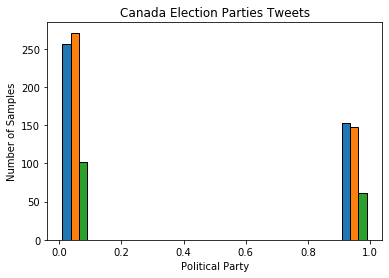

In [0]:
plt.hist(value_list, bins=10, edgecolor='black')
plt.title("Canada Election Parties Tweets")
plt.xlabel("Political Party")
plt.ylabel("Number of Samples")
plt.show()

In [0]:
conservative_true=election_tweets.loc[election_tweets['party']=='conservative','sentiment']
liberal_true=election_tweets.loc[election_tweets['party']=='liberal','sentiment']
ndp_true=election_tweets.loc[election_tweets['party']=='ndp','sentiment']
true_ValueList=[conservative_true,liberal_true,ndp_true]

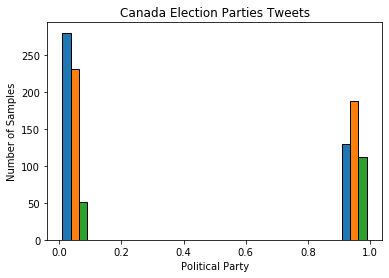

In [0]:
plt.hist(true_ValueList, bins=10, edgecolor='black')
plt.title("Canada Election Parties Tweets")
plt.xlabel("Political Party")
plt.ylabel("Number of Samples")
plt.show()

From ground truth we can see that majority of the tweets about liberal and conservative are negative but for ndp the positive tweet take the trend.

Compare the two graphs above we can see that all three paries have more negative predictions than their ground truth labels, and from the prediction accuracy I think the analysis on generic tweets has little help on predicting the sentiment of election tweets. Here are the potential reasons, the features in generic tweets and election tweet has huge difference and this difference in feature dimension causes a significant bias when applied to election tweet. 

In [0]:
election_tweets.head()

,sentiment,negative_reason,text,party
0,0,Women Reproductive right and Racism,b rosiebarton so instead of your suggestion ho...,conservative
1,1,NaN,b allwomanspacewalk it real etobicokenorth cit...,none
2,0,Economy,b brantford it going to cost you billion for t...,liberal
3,1,NaN,b canada canadavotes decide this should help,none
4,0,Economy,b canada taxpayers are sick amp tired of havin...,liberal


In [0]:

reasons=election_tweets['negative_reason'].unique()
reasons=reasons.tolist()
cleanedList = [x for x in reasons if str(x) != 'nan']#remove nan
print(cleanedList)

['Women Reproductive right and Racism', 'Economy', 'Others', 'Scandal', 'Tell lies', 'Privilege', 'Climate Problem', 'Healthcare', 'Separation', 'Healthcare and Marijuana']


In [0]:
'''def one_HotEncoding(data,label_List):
  
  a = np.zeros(shape=(len(data),10))
  #print(a.shape)
  result=pd.DataFrame(a,columns=label_List)
  print(result.shape)
  for index in range(len(data)):
    result.loc[index,data[index]]=1
    #print(data[index][1])
  #print(result.shape)
  
  return result'''
def one_HotEncoding(data,label_List):
  label_Dict={'Women Reproductive right and Racism':1,'Economy':2,'Others':3,'Scandal':4,'Tell lies':5,'Privilege':6,'Climate Problem':7,'Healthcare':8,'Separation':9, 'Healthcare and Marijuana':10}
  a = np.zeros(shape=(len(data),1))
  #print(a.shape)
  result=pd.DataFrame(a,columns=['label'])
  print(result.shape)
  for index in range(len(data)):
    result.loc[index,'label']=label_Dict[data[index]]
    #print(data[index][1])
  #print(result.shape)
  
  return result

In [0]:
labeled_election_tweets=election_tweets[election_tweets['negative_reason'].notnull()]

onehot_Label=one_HotEncoding(labeled_election_tweets['negative_reason'].values,cleanedList)

(1007, 1)


In [0]:
onehot_Label.head()

,label
0,1.0
1,2.0
2,2.0
3,3.0
4,3.0


In [0]:
l1=labeled_election_tweets.index
l2=np.arange(0,len(l1))
labeled_election_tweets = labeled_election_tweets.rename(index=dict(zip(l1,l2)))#rename dataframe index!!!!
labeled_election_tweets=pd.concat([labeled_election_tweets,onehot_Label],axis=1)#combine two dataframe!!!

In [0]:
labeled_election_tweets.head()

,sentiment,negative_reason,text,party,label
0,0,Women Reproductive right and Racism,b rosiebarton so instead of your suggestion ho...,conservative,1.0
1,0,Economy,b brantford it going to cost you billion for t...,liberal,2.0
2,0,Economy,b canada taxpayers are sick amp tired of havin...,liberal,2.0
3,0,Others,b cdnpoli facts blastfromthepast in conservati...,conservative,3.0
4,0,Others,b chooseforward cdnpoli do make america mistak...,none,3.0


In [0]:
tfidf_election=getTfidfFeatures(labeled_election_tweets['text'])

In [0]:
elec_trainData,elec_testData,elec_trainLabel,elec_testLabel=train_test_split(tfidf_election, onehot_Label, test_size=0.3)

In [0]:
elecLG_train,elecLG_test=Log_Reg(elec_trainData, elec_trainLabel, elec_testData, elec_testLabel)
print(elecLG_train,elecLG_test)

0.6221590909090909 0.429042904290429


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
elecNB_train,elecNB_test=nbClassifier(elec_trainData, elec_trainLabel, elec_testData, elec_testLabel)
print(elecNB_train,elecNB_test)

0.703125 0.3432343234323432


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
elecDT_train,elecDT_test=DTClassfier(elec_trainData, elec_trainLabel, elec_testData, elec_testLabel)
print(elecDT_train,elecDT_test)

fit
train
test
0.5553977272727273 0.46534653465346537


Potential Wrong Prediciton Cause: Some tweets criticized more than one aspect of the party like in tweet 276 was labeled as tell lies but the publisher also criticized the women rights, thus may introduce some misleading information for classification. In addition, the label is not in one hot format, for some high valued label like 9 and 10, these labels are biased compared to others, which make the model hard to converge on them.

Ways to Improve:
1.Increase the dimension of feature space, so that the chances of election tweets and generic tweet to have same feature will increase.
2.
The sklearn classifier take one dimension label which force me to mark the different reasons as values from 1 to 10 which is not so well as one hot encoding label, convert the label into one hot format should be able to improve the performance of the second model.

#Bonus

###N_Gram Feature Extraction

In [0]:
import re
import gensim
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
generic_tweets.head()

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting cry result ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived times ball managed save 50 rest...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,body feels itchy fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad cant


In [0]:
generic_CTs=generic_tweets['cleaned_text'].apply(lambda data: nltk.word_tokenize(data))
generic_CTs=generic_CTs.apply(lambda x: [item for item in x if item.isalpha()])

#list(ngrams(['van','bill','arthur','car','sword'], 3))
'''counter=CountVectorizer(ngram_range=(2,2))
X = counter.fit_transform(generic_tweets['cleaned_text'].values)'''

"counter=CountVectorizer(ngram_range=(2,2))\nX = counter.fit_transform(generic_tweets['cleaned_text'].values)"

In [0]:
ngram_Tweets=generic_CTs.apply(lambda data:ngrams(data,2) )
ngram_Tweets=ngram_Tweets.apply(lambda data:list(data) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'ngrams' raised StopIteration
  


In [0]:
ngram_list=[]
for item in ngram_Tweets:
  for x in item:
    x=' '.join(x)
    ngram_list.append(x)

In [0]:
counter=Counter()
counter.update(item for item in ngram_list)

In [0]:
ngramfeature_List=counter.most_common(500)

In [0]:
for index in range(len(ngramfeature_List)):
  ngramfeature_List[index]=ngramfeature_List[index][0]
print(ngramfeature_List)

['cant wait', 'good morning', 'cant sleep', 'mothers day', 'good night', 'good luck', 'going bed', 'good day', 'great day', 'feel better', 'dont wan', 'cant find', 'happy birthday', 'school tomorrow', 'work tomorrow', 'work today', 'beautiful day', 'day today', 'dont feel', 'nice day', 'long day', 'swine flu', 'going sleep', 'happy mothers', 'day work', 'ice cream', 'long time', 'fall asleep', 'bank holiday', 'ready work', 'great time', 'sunny day', 'feel bad', 'good thing', 'hannah montana', 'good time', 'going work', 'pretty good', 'sun shining', 'best friend', 'hope great', 'sounds good', 'wait till', 'doesnt work', 'feeling better', 'hope good', 'dont work', 'day tomorrow', 'good times', 'dont worry', 'great weekend', 'feel good', 'ha ha', 'great night', 'hope well', 'star trek', 'sore throat', 'feeling well', 'lovely day', 'sunday morning', 'sweet dreams', 'hours sleep', 'hope feel', 'didnt work', 'spring break', 'late night', 'going school', 'feel sick', 'saturday night', 'today 

I used a bigram processing tool from nltk and selected the top 500 2-grams by term frequency, the extracted 2-grams phrases can be used to form a training dataset via word2vec or other embedding methods.

###RNN Text Classification

In [0]:
import pandas as pd
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [0]:
print(tf.__version__)

2.0.0


In [0]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,Dropout,Flatten
from keras.layers import LSTM
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [0]:
tfidf_trainData=tfidf_trainData.values
tfidf_trainLabel=tfidf_trainLabel.values
tfidf_testData=tfidf_testData.values
tfidf_testLabel=tfidf_testLabel.values


tfidf_trainData = np.reshape(tfidf_trainData, (tfidf_trainData.shape[0], 1, tfidf_trainData.shape[1]))
tfidf_testData = np.reshape(tfidf_testData, (tfidf_testData.shape[0], 1, tfidf_testData.shape[1]))



In [0]:
model.fit(tfidf_trainData,tfidf_trainLabel,
          batch_size=100,
          epochs=5,
          validation_data=(tfidf_testData[:10000], tfidf_testLabel[:10000]))

Train on 140000 samples, validate on 10000 samples
Epoch 1/5
140000/140000 [==============================] - 19s 134us/sample - loss: 0.1914 - accuracy: 0.7005 - val_loss: 0.1907 - val_accuracy: 0.6993
Epoch 2/5
140000/140000 [==============================] - 17s 123us/sample - loss: 0.1912 - accuracy: 0.7009 - val_loss: 0.1914 - val_accuracy: 0.6995
Epoch 3/5
140000/140000 [==============================] - 17s 124us/sample - loss: 0.1911 - accuracy: 0.7013 - val_loss: 0.1912 - val_accuracy: 0.7001
Epoch 4/5
140000/140000 [==============================] - 17s 123us/sample - loss: 0.1909 - accuracy: 0.7012 - val_loss: 0.1907 - val_accuracy: 0.7001
Epoch 5/5
140000/140000 [==============================] - 17s 123us/sample - loss: 0.1908 - accuracy: 0.7014 - val_loss: 0.1906 - val_accuracy: 0.6990


In [0]:
scores,acc = model.evaluate(tfidf_trainData, tfidf_trainLabel, verbose=0)
print(acc)

test_scores,testacc = model.evaluate(tfidf_testData[10000:], tfidf_testLabel[10000:], verbose=0)
print(testacc)

0.70199287
0.70022


In this section, I implemented a recurrent neural network on LTSM model, which consists of three layer,the LSTM layer acts as both the input layer and hidden layer(since the input is tf_idf encodded, there is no need to design an input layer to embed the raw text) with 128 elements, a flatten layer and a fully connected dense layer for output. The training take a batch size of 100 with 5 epochs in total, the testing result is 0.70022 which was better than that of logstic regression, and I suppose the accuracy can still be imporved with more advanced word embedding techniques.